In [1]:
import  numpy as np
import matplotlib as plt

In [48]:
from qiskit import BasicAer, Aer, IBMQ,execute
from qiskit import QuantumRegister ,ClassicalRegister,QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.aqua.operators import I, X, Y, Z

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

from qiskit import IBMQ

In [18]:
#jut a dirty trick
from scipy.optimize import minimize
from tools import decompose, expected
from tools import ansatz_cell,var_circ
from tools import value, cost, Exact_solver

from tools import I,X,Y,Z,U_t
from tools import get_x,comutation,corelation,new_state

In [4]:
#local simulator
backend=Aer.get_backend('qasm_simulator')

In [5]:
basis='sto3g'
inter_dist=1.4
# Molecule
atoms = 'Li .0 .0 .0; H .0 .0 '+str(inter_dist)
driver = PySCFDriver(atoms, unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis,max_memory=None)

#integral h_{lm} , h_{lmpq}
molecule = driver.run()
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

#freez some
freeze_list = [0]
remove_list = [-3, -2]

remove_list = [x % molecule.num_orbitals for x in remove_list]
freeze_list = [x % molecule.num_orbitals for x in freeze_list]
remove_list = [x - len(freeze_list) for x in remove_list]
remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    


print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))

ferOp = FermionicOperator(h1=h1, h2=h2)

ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
num_spin_orbitals -= len(freeze_list)
num_particles -= len(freeze_list)

ferOp = ferOp.fermion_mode_elimination(remove_list)
num_spin_orbitals -= len(remove_list)

qubitOp = ferOp.mapping(map_type='jordan_wigner')

print("!! After freezing and remouve:")
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print('Freez energy shift: {}'.format(energy_shift))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))

HF energy: -8.994489827277834
# nr. of electrons: 4
# nr. of spin orbitals: 12
!! After freezing and remouve:
HF energy: -8.994489827277834
Freez energy shift: -7.890791483133478
# nr. of electrons: 2
# nr. of spin orbitals: 6


In [6]:
weight=[]
pauli=[]
for w,i in qubitOp._paulis:
    weight.append(w)
    pauli.append(i.to_label())
    
for i in range(len(weight)):
    print("{}-{}".format(pauli[i],weight[i]))

IIIIII-(-0.195376755616701+0j)
IIIIIZ-(-0.035588470492344565+0j)
IIIIYY-(-0.0003318754139285756+0j)
IIIIXX-(-0.0003318754139285756+0j)
IIIYZY-(-0.002855354011152835+0j)
IIIXZX-(-0.002855354011152835+0j)
IIIIZI-(-0.1271287364122908+0j)
IIIYYI-(0.015487042720236696+0j)
IIIXXI-(0.015487042720236696+0j)
IIIZII-(-0.32797339053955066+0j)
IIZIII-(-0.035588470492344614+0j)
IYYIII-(-0.000331875413928576+0j)
IXXIII-(-0.000331875413928576+0j)
YZYIII-(-0.0028553540111528396+0j)
XZXIII-(-0.0028553540111528396+0j)
IZIIII-(-0.12712873641229083+0j)
YYIIII-(0.015487042720236694+0j)
XXIIII-(0.015487042720236694+0j)
ZIIIII-(-0.3279733905395506+0j)
IIIIZZ-(0.05465159002074206+0j)
IIIYYZ-(0.004528580551868638+0j)
IIIXXZ-(0.004528580551868638+0j)
IIIZIZ-(0.08440311056673275+0j)
IIIYIY-(0.003360334818433897+0j)
IIIXIX-(0.003360334818433897+0j)
IIIZYY-(0.0026416812148497334+0j)
IIIZXX-(0.0026416812148497334+0j)
IIZIIZ-(0.12532519013543403+0j)
IIZIYY-(0.011343530738243493+0j)
IIZIXX-(0.011343530738243493+0j)
I

theta = [0. 0. 0. 0. 0. 0. 0. 0.]
(-0.9527139393899218+0j)


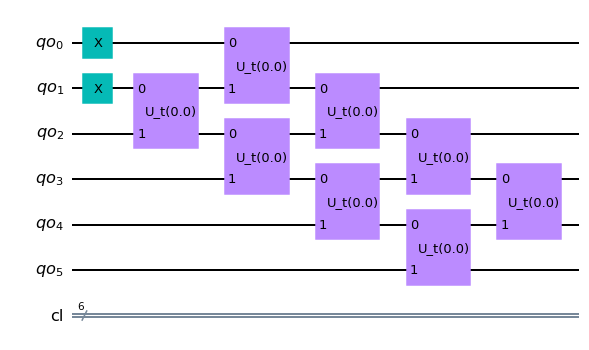

In [7]:
#initial circuit :
nr_o=num_spin_orbitals
nr_e=num_particles
nr_par=(nr_o-nr_e)*nr_e
theta=np.zeros(nr_par)
qo=QuantumRegister(nr_o,'qo')
ansatz = QuantumCircuit(qo)
ansatz_cell(ansatz,qo,nr_o, nr_e,theta)
ansatz.draw('mpl')
circ=var_circ(nr_o,nr_e,theta)
print('theta =',theta)
print(value(weight,pauli,circ,backend))
circ.draw('mpl')

In [8]:
#compression

In [9]:
class x_op:
    def __init__(self,size):
        self.size=size
        self.elements=get_x(size)
        self.label,self.coef=self.labels()
    def labels(self):
        labels=[]
        coef=[]
        for j in self.elements:
            l=[]
            c=[]
            x_j,x_label=decompose(j)
            for i in range(len(x_j)):
                if(abs(x_j[i])!=0):
                    l.append(x_label[i])
                    c.append(x_j[i])
            labels.append(l)
            coef.append(c)
        return labels, coef
    def info(self):
        print('size:',self.size)
        label=self.label
        coef=self.coef
        print('nr. elements:',len(label))
        for i in range(len(label)):
            print('x_{}'.format(i))
            print('labels:',label[i])
            print('coef:',coef[i])

In [17]:
# 2 Qubit pseudo compression o
op_2=x_op(2)
op_2.info()

size: 2
nr. elements: 4
x_0
labels: ['XI']
coef: [(1+0j)]
x_1
labels: ['YI']
coef: [(1+0j)]
x_2
labels: ['ZX']
coef: [(1+0j)]
x_3
labels: ['ZY']
coef: [(1+0j)]


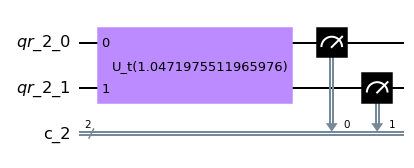

In [21]:
# initial circuit 
qr=QuantumRegister(2,'qr_2')
c=ClassicalRegister(2,'c_2')
qc_2=QuantumCircuit(qr,c)

qc_2.append(U_t(np.pi/3),qr)
qc_2.measure(qr,c)

qc_2.draw('mpl')

In [30]:
init=np.zeros((2**2,2**2))
init[0][0]=1
print("Initial density:")
for i in init:
    print(i)
    
    
new=new_state(init,op_2)
print("\n New density:")
for i in new:
    print(i)


Initial density:
[1. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]

 New density:
[0.25+0.j 0.5 +0.j 0.  +0.j 0.  +0.j]
[-0.5 +0.j  0.25+0.j  0.  +0.j  0.  +0.j]
[0.  +0.j 0.  +0.j 0.25+0.j 0.5 +0.j]
[ 0.  +0.j  0.  +0.j -0.5 +0.j  0.25+0.j]


In [34]:
I

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [33]:
Q_2=[[0.25,0.5],
     [-0.5,0.25]]

In [ ]:
np.kron(I,I)

In [39]:
np.kron(I,Q_2)

array([[ 0.25+0.j,  0.5 +0.j,  0.  +0.j,  0.  +0.j],
       [-0.5 +0.j,  0.25+0.j, -0.  +0.j,  0.  +0.j],
       [ 0.  +0.j,  0.  +0.j,  0.25+0.j,  0.5 +0.j],
       [-0.  +0.j,  0.  +0.j, -0.5 +0.j,  0.25+0.j]])

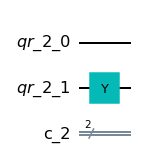

In [84]:
# pseudo compres
qr=QuantumRegister(2,'qr_2')
c=ClassicalRegister(2,'c_2')
qc_2=QuantumCircuit(qr,c)

#qc_2.unitary(2*Q_2,qr[1])
qc_2.y(qr[1])
#qc_2.measure(qr,c)

qc_2.draw('mpl')

In [85]:
statevector_bg=Aer.get_backend('statevector_simulator')

In [86]:
exp=execute(qc_2,backend=statevector_bg)
result=exp.result()
statevector=result.get_statevector(qc_2,decimals=1)
print(statevector)

[0.-0.j 0.-0.j 0.+1.j 0.+0.j]


In [83]:
backend = Aer.get_backend('unitary_simulator')
job = execute(qc_2, backend)
result = job.result()
unitary=result.get_unitary(qc_2, decimals=1)

for i in unitary:
    print(i)

[0.-0.j 0.-1.j 0.-0.j 0.-0.j]
[0.+1.j 0.+0.j 0.+0.j 0.+0.j]
[0.-0.j 0.-0.j 0.-0.j 0.-1.j]
[0.+0.j 0.+0.j 0.+1.j 0.+0.j]


In [45]:
new
print(new.trace())

(1+0j)


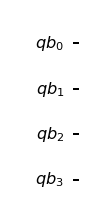

In [15]:
qb=QuantumRegister(4,'qb')
qc=QuantumCircuit(qb)
#qc.unitary(new,qb)
qc.initialize
qc.draw('mpl')

In [ ]:
class major:
    def __init__(self,index,size):
        self.index=index
        self.size=size
    
    
        

In [27]:
#comprssion
# inital state : r=1\(2n)[I+iC(r_{in})]
# C=</psi_{in}|ic_jc_k|/psi_{in}>

I_2n=np.identity(2*nr_o)
C=np.zeros((2*nr_o,2*nr_o))
print('C:')
for i in C:
    print(i)
    

C:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [28]:
for i in I_2n:
    print(i)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
